In [184]:
import numpy as np
import pandas as pd
import datetime as dt
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  
import seaborn as sns

In [185]:
df = pd.read_excel('Assignment 3 - timeseries_data.xlsx')
df['DATETIME'] = pd.to_datetime(df.DATETIME)
df.set_index('DATETIME',inplace = True)

# EDA

In [186]:
df.describe()

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,YEAR
count,14987.000000,14982.000000,14983.000000,14987.000000,14987.000000,14987.000000
mean,25.766417,7532.436283,291.989714,42371.673703,12.495763,2017.415493
std,46.361945,3992.884834,370.914596,9874.339631,6.922309,0.492823
min,-17.860000,54.440000,0.000000,25566.511248,1.000000,2017.000000
25%,18.041250,4135.630000,0.000000,35431.636526,6.000000,2017.000000
50%,20.057500,7281.445000,22.150000,39934.007113,12.000000,2017.000000
75%,25.030000,10851.647500,608.635000,47873.100786,18.000000,2018.000000
max,2809.357500,20350.400000,1257.540000,73264.662123,24.000000,2018.000000


In [187]:
## Check missing values
print(df.isnull().sum())
## Since we only have few missings for columns 'ERCOT (WIND_RTI)' and 'ERCOT (GENERATION_SOLAR_RT)'
## It is safe to drop them
df.dropna(inplace = True)

HB_NORTH (RTLMP)               0
ERCOT (WIND_RTI)               5
ERCOT (GENERATION_SOLAR_RT)    4
ERCOT (RTLOAD)                 0
HOURENDING                     0
MARKETDAY                      0
PEAKTYPE                       0
MONTH                          0
YEAR                           0
dtype: int64


In [188]:
## Check duplicates
sum(df.duplicated())
## No duplicates

0

In [189]:
## Check correlation
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm') 
## The dependent variable does not show strong correlation with any feature. 
## The good news is no pair of explaintory variables shows high correlation. We will avoid multicollinearity problem.

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,YEAR
HB_NORTH (RTLMP),1,-0.151156,0.15191,0.238481,0.0880685,0.0642173
ERCOT (WIND_RTI),-0.151156,1,-0.235325,-0.16671,-0.0355685,0.125908
ERCOT (GENERATION_SOLAR_RT),0.15191,-0.235325,1,0.466309,0.178857,0.163086
ERCOT (RTLOAD),0.238481,-0.16671,0.466309,1,0.424417,0.185986
HOURENDING,0.0880685,-0.0355685,0.178857,0.424417,1,-0.000828112
YEAR,0.0642173,0.125908,0.163086,0.185986,-0.000828112,1


In [190]:
## Check time series continuity
deltas = df.index.to_series().diff()[1:]
gaps = deltas[deltas > dt.timedelta(hours=1)]
print(gaps)
## Not much discontinuity
## Fill the gap with previous values
df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq='60min'))
df.fillna(method = 'ffill',inplace = True)

DATETIME
2017-03-12 04:00:00   02:00:00
2017-11-05 03:00:00   03:00:00
2018-03-11 04:00:00   03:00:00
Name: DATETIME, dtype: timedelta64[ns]


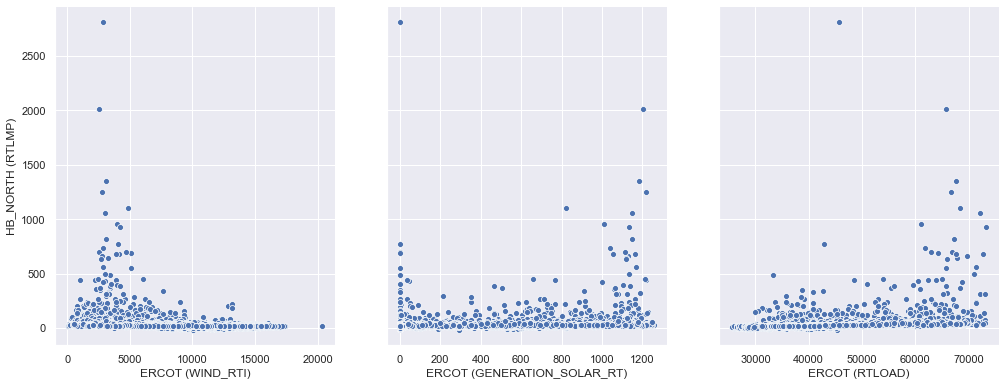

In [191]:
## Scatter plots
g = sns.pairplot(df, y_vars="HB_NORTH (RTLMP)", x_vars=['ERCOT (WIND_RTI)','ERCOT (GENERATION_SOLAR_RT)','ERCOT (RTLOAD)'])
g.fig.set_size_inches(15,7)

<AxesSubplot:xlabel='HB_NORTH (RTLMP)'>

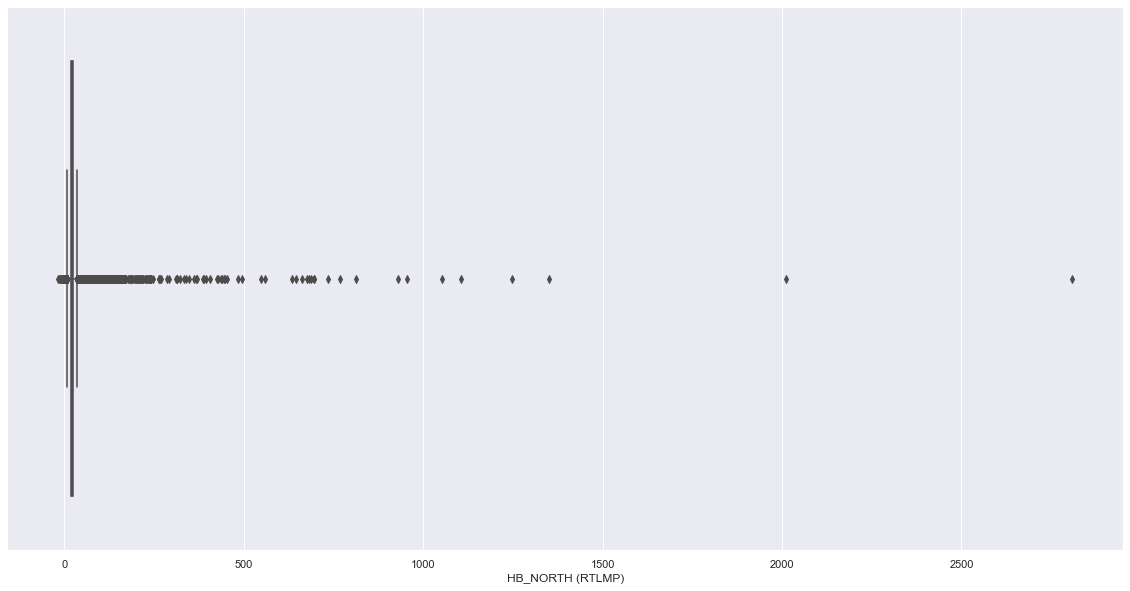

In [171]:
## Outliers
plt.figure(figsize=(20, 10))
sns.boxplot(x=df["HB_NORTH (RTLMP)"])

# Feature engineering

In [158]:
def feature_engineering(df):
    df['PEAKTYPE'] = df['PEAKTYPE'].apply(lambda x:0 if x=='OFFPEAK' else 1) ## 
    df['MONTH'] = df.index.to_series().apply(lambda x:x.month) ## Convert categorical data to numerics
    ## Make hour of day cyclic
    df['xhr']=df['HOURENDING'].apply(lambda x:math.sin(2*math.pi*x/24))
    df['yhr'] = df['HOURENDING'].apply(lambda x:math.cos(2*math.pi*x/24))
    
    df = df[['HB_NORTH (RTLMP)','ERCOT (WIND_RTI)','ERCOT (GENERATION_SOLAR_RT)','ERCOT (RTLOAD)','PEAKTYPE','xhr','yhr']]
    
    ## Add lag terms
    for column in ['HB_NORTH (RTLMP)','ERCOT (WIND_RTI)','ERCOT (GENERATION_SOLAR_RT)','ERCOT (RTLOAD)']:
        for lag in [1,6,12,24,72,168]:
            column_name = column + '_'+str(lag)+'hours_lag'
            df[column_name] = df[column].shift(lag)
    

    df.dropna(inplace = True)
    return df

In [159]:
df = feature_engineering(df)

C:\Users\kaina\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [160]:
df.head(5)

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),PEAKTYPE,xhr,yhr,HB_NORTH (RTLMP)_1hours_lag,HB_NORTH (RTLMP)_6hours_lag,HB_NORTH (RTLMP)_12hours_lag,...,ERCOT (GENERATION_SOLAR_RT)_12hours_lag,ERCOT (GENERATION_SOLAR_RT)_24hours_lag,ERCOT (GENERATION_SOLAR_RT)_72hours_lag,ERCOT (GENERATION_SOLAR_RT)_168hours_lag,ERCOT (RTLOAD)_1hours_lag,ERCOT (RTLOAD)_6hours_lag,ERCOT (RTLOAD)_12hours_lag,ERCOT (RTLOAD)_24hours_lag,ERCOT (RTLOAD)_72hours_lag,ERCOT (RTLOAD)_168hours_lag
2017-01-08 01:00:00,20.0550,10733.93,0.06,49070.870950,0,0.258819,0.965926,22.0175,25.6225,27.555,...,431.57,0.23,0.06,0.0,49908.424713,48589.184615,49772.613193,53876.795135,37240.882430,29485.791355
2017-01-08 02:00:00,20.8900,11049.04,0.06,48812.171708,0,0.500000,0.866025,20.0550,25.3100,23.610,...,439.61,0.23,0.06,0.0,49070.870950,50211.863938,46789.047328,53345.683498,36310.229830,28911.565913
2017-01-08 03:00:00,20.3025,11274.26,0.06,48771.690930,0,0.707107,0.707107,20.8900,23.9850,21.655,...,446.84,0.23,0.06,0.0,48812.171708,51099.641395,44305.385008,53276.788955,35746.991105,28238.258175
2017-01-08 04:00:00,20.6100,11232.75,0.06,49037.970748,0,0.866025,0.500000,20.3025,22.7600,21.055,...,439.03,0.23,0.06,0.0,48771.690930,51224.520410,42701.449510,53512.838338,35696.076695,27821.000513
2017-01-08 05:00:00,21.0975,11390.74,0.06,49613.045535,0,0.965926,0.258819,20.6100,22.6400,21.155,...,313.01,0.23,0.06,0.0,49037.970748,50651.997228,42381.753373,54144.341955,36368.485593,27646.942413


# Modeling

In [161]:
## Train/test split
from sklearn.model_selection import train_test_split
X = df.drop(['HB_NORTH (RTLMP)'],axis = 1)
y = df['HB_NORTH (RTLMP)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,shuffle = True,random_state = 1)

In [162]:
## Baseline model
## Use previous RTLMP as prediction 
## Select RMSE as metric
y_pred_baseline = X_test['HB_NORTH (RTLMP)_1hours_lag']
print((metrics.mean_squared_error(y_pred_baseline, y_test))**0.5)

38.28270374350038


In [163]:
## RF
rf = RandomForestRegressor( max_features = 'sqrt',random_state=1)
rf.fit(X_train, y_train)
## Feature selection based on feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
list_ = feature_importances.iloc[:10].index.tolist()

C:\Users\kaina\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [164]:
## New RF model after feature selection
X = df[list_]
y = df['HB_NORTH (RTLMP)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,shuffle = True,random_state = 1)
rf = RandomForestRegressor( max_features= 'sqrt',random_state=1)
rf.fit(X_train, y_train)
print((metrics.mean_squared_error(rf.predict(X_test), y_test))**0.5)

C:\Users\kaina\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


34.58211950112316


In [194]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
HB_NORTH (RTLMP)_1hours_lag,0.291595
ERCOT (GENERATION_SOLAR_RT),0.213062
ERCOT (RTLOAD)_168hours_lag,0.073174
ERCOT (GENERATION_SOLAR_RT)_72hours_lag,0.071507
ERCOT (RTLOAD),0.065356
HB_NORTH (RTLMP)_24hours_lag,0.058312
HB_NORTH (RTLMP)_12hours_lag,0.058282
ERCOT (WIND_RTI)_1hours_lag,0.058005
ERCOT (RTLOAD)_1hours_lag,0.055830
ERCOT (RTLOAD)_6hours_lag,0.054875
